## Defensive Capacity

#### Load data & packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/pgule/Documents/Sample Data/epl.csv', delimiter=',')

In [2]:
df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter=';')

### General grouping of data into dfs

In [3]:
df_prop = pd.DataFrame({
    'column_name': df.columns,
    'data_type': df.dtypes.values
})

In [4]:
df_vals = pd.DataFrame({
    'column_name': df.columns,
    'column_values': [set(df[col].tolist()) for col in df.columns],
    'unique_value_count': [len(set(df[col].tolist())) for col in df.columns]
})

In [7]:
df_vals

,column_name,column_values,unique_value_count
0,season_id,{2012},1
1,match_id,"{442368, 442369, 442370, 442371, 442372, 44237...",380
2,home_team_id,"{1, 3, 4, 6, 7, 8, 11, 14, 20, 21, 35, 43, 45,...",20
3,home_team_name,"{Liverpool, Sunderland, Queens Park Rangers, N...",20
4,away_team_id,"{1, 3, 4, 6, 7, 8, 11, 14, 20, 21, 35, 43, 45,...",20
5,away_team_name,"{Liverpool, Sunderland, Queens Park Rangers, N...",20
6,id,"{543162368, 1138753537, 123731970, 920649732, ...",648883
7,event_id,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1160
8,date,"{28Nov2012, 23Sep2012, 13Mar2013, 06Oct2012, 2...",107
9,time,"{2:02:19 PM, 8:13:23 PM, 4:41:06 PM, 5:13:13 P...",31752


### Define team_id: team_name dictionary

In [8]:
teams1 = df['home_team_name'].unique()
teams2 = df['away_team_name'].unique()

teams = set(teams2) | set(teams2)

In [12]:
teams

{'Arsenal',
 'Aston Villa',
 'Chelsea',
 'Everton',
 'Fulham',
 'Liverpool',
 'Manchester City',
 'Manchester United',
 'Newcastle United',
 'Norwich City',
 'Queens Park Rangers',
 'Reading',
 'Southampton',
 'Stoke City',
 'Sunderland',
 'Swansea City',
 'Tottenham Hotspur',
 'West Bromwich Albion',
 'West Ham United',
 'Wigan Athletic'}

In [9]:
team_id_name_dict = {}

In [10]:
for team in teams:
    team_id = df[df['home_team_name'] == team]['team_id'].values[0]
    team_id_name_dict[team_id] = team

In [11]:
team_id_name_dict

{np.int64(14): 'West Bromwich Albion',
 np.int64(56): 'Sunderland',
 np.int64(80): 'Swansea City',
 np.int64(45): 'Norwich City',
 np.int64(7): 'Aston Villa',
 np.int64(20): 'Manchester City',
 np.int64(4): 'Newcastle United',
 np.int64(8): 'Chelsea',
 np.int64(1): 'Manchester United',
 np.int64(110): 'Stoke City',
 np.int64(111): 'Wigan Athletic',
 np.int64(6): 'Tottenham Hotspur',
 np.int64(3): 'Arsenal',
 np.int64(54): 'Fulham',
 np.int64(11): 'Everton'}

### Set relevant events

In [111]:
one_defensive_events = ['Interception', 'Save', 'Ball recovery', 'Error', 'Offside provoked', 'Shield ball opp']
cero_defensive_events = ['Foul', 'Challenge']
binary_defensive_events = ['Tackle', 'Clearance', 'Aerial']

In [112]:
defensive_events = {
    'Interception': {'successful': 1},
    'Save': {'successful': 1},
    'Ball recovery': {'successful': 1},
    'Error': {'unsuccessful': 1},
    'Offside provoked': {'successful': 1},
    'Shield ball opp': {'successful': 1},
    'Challenge': {'unsuccessful': 0},
    'Foul': {'unsuccessful': 0},  # Mantenemos solo el valor que te interesa
    'Tackle': {'successful': 1, 'unsuccessful': 0},
    'Clearance': {'successful': 1, 'unsuccessful': 0},
    'Aerial': {'successful': 1, 'unsuccessful': 0},
}



In [113]:
dangerous_first_half = (0,30)
dangerous_second_half = (70,100)

### Player event collection

In [114]:
player_stats = []
player_names = df['playerName'].unique()

In [115]:
for player_name in player_names:
    if player_name == 'nan' or player_name == 'NaN':
        pass
    else:
        # Para resultados más rápidos
        player_df = df[df['playerName'] == player_name]
        
        if not player_df.empty:
            # Recopilar equipo y asignar posición
            team_id = player_df['team_id'].iloc[0] if not player_df['team_id'].empty else None
            position = None

            # Buscar una posición válida --> se considera que substitute no es válido
            for pos in player_df['playerPosition']:
                if pos.lower() != 'substitute':  
                    position = pos
                    break  # cuando se encuentra, se detiene
            stats = {
                'player_name': player_name,
                'team_id': team_id,
                'position': position,
            }

            total_defensive_events = 0
            successful_defensive_events = 0

            for event, outcomes in defensive_events.items():
                # Filtrar para excluir los Foul con outcome = 1
                if event == 'Foul':
                    total_event_count = player_df[(player_df['description'] == event) & (player_df['outcome'] == 0)].shape[0]
                else:
                    total_event_count = player_df[player_df['description'] == event].shape[0]
                
                stats[f'total_{event.lower().replace(" ", "_")}'] = total_event_count
                total_defensive_events += total_event_count

                if 'successful' in outcomes:
                    # Filtrar para excluir Foul con outcome = 1 también aquí
                    if event == 'Foul':
                        successful_event_count = player_df[(player_df['description'] == event) & (player_df['outcome'] == 0)].shape[0]
                    else:
                        successful_event_count = player_df[(player_df['description'] == event) & (player_df['outcome'] == outcomes['successful'])].shape[0]
                    
                    stats[f'successful_{event.lower().replace(" ", "_")}'] = successful_event_count
                    successful_defensive_events += successful_event_count

                for outcome_name, outcome_value in outcomes.items():
                    if outcome_name != 'successful':
                        if event == 'Foul' and outcome_value == 1:
                            continue  # Ignorar Foul con outcome = 1
                        outcome_event_count = player_df[(player_df['description'] == event) & (player_df['outcome'] == outcome_value)].shape[0]
                        stats[f'{outcome_name}_{event.lower().replace(" ", "_")}'] = outcome_event_count

            stats['defensive_capacity'] = successful_defensive_events / total_defensive_events if total_defensive_events > 0 else 0

            player_stats.append(stats)


In [116]:
df_players = pd.DataFrame(player_stats)

In [117]:
df_players

,player_name,team_id,position,total_interception,successful_interception,total_save,successful_save,total_ball_recovery,successful_ball_recovery,total_error,...,total_tackle,successful_tackle,unsuccessful_tackle,total_clearance,successful_clearance,unsuccessful_clearance,total_aerial,successful_aerial,unsuccessful_aerial,defensive_capacity
0,"Podolski, Lukas",3,Striker,15,15,2,2,68,68,3,...,32,25,7,23,10,13,77,25,52,0.543071
1,"Cazorla, Santiago",3,Midfielder,69,69,1,1,247,247,0,...,71,55,16,18,8,10,18,7,11,0.769384
2,"Vermaelen, Thomas",3,Defender,47,47,19,19,89,89,6,...,43,35,8,139,85,54,121,67,54,0.707031
3,"Walcott, Theo",3,Midfielder,11,11,0,0,89,89,0,...,16,15,1,5,0,5,25,7,18,0.742515
4,"Sessegnon, Stephane",56,Midfielder,11,11,2,2,97,97,1,...,20,17,3,7,3,4,80,17,63,0.558052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,"Ibe, Jordon",14,Midfielder,1,1,0,0,8,8,0,...,1,1,0,0,0,0,0,0,0,0.909091
519,"Knott, Billy",56,None,0,0,0,0,2,2,0,...,0,0,0,0,0,0,1,0,1,0.666667
520,"Mitchell, Adam",56,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
521,"Fyvie, Fraser",111,None,1,1,0,0,2,2,0,...,1,1,0,0,0,0,0,0,0,1.000000


In [119]:
df_sorted = (df_players[df_players['position'].notna()]).sort_values(by='defensive_capacity', ascending=False)

In [120]:
df_sorted_no_gk = df_sorted[df_sorted['position']!='Goalkeeper']

In [121]:
team_dfs = {}

In [124]:
for team_id in df_sorted['team_id'].unique():
    team_dfs[team_id] = df_sorted[df_sorted['team_id'] == team_id].copy()
    team_dfs[team_id]['team_name'] = team_dfs[team_id]['team_id'].map(team_id_name_dict)


In [125]:
defenders_sums = {}
midfielders_sums = {}
strikers_sums = {}

for event, outcome in defensive_events.items():
    if 'successful' in outcome:
        event_rename = 'successful_' + event.lower().replace(" ", "_")
        position_sums = df_players.groupby('position')[event_rename].sum()

        defenders_sums[event] = position_sums.get('Defender', 0)
        midfielders_sums[event] = position_sums.get('Midfielder', 0)
        strikers_sums[event] = position_sums.get('Striker', 0)
        

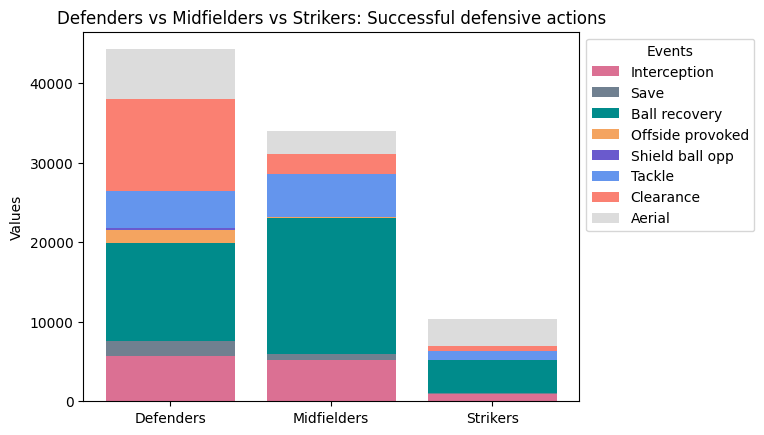

In [126]:
positions = ['Defenders', 'Midfielders', 'Strikers']

cumulative_sums = np.zeros(len(positions))

color_scheme = {
    'Ball recovery': 'darkcyan',
    'Interception': 'palevioletred',
    'Clearance': 'salmon',
    'Tackle': 'cornflowerblue',
    'Save': 'slategrey',
    'Error': 'darkseagreen',
    'Offside provoked': 'sandybrown',
    'Shield ball opp': 'slateblue',
    'Take on': 'crimson',
    'Foul': 'bisque',
    'Aerial': 'gainsboro'
}

fig, ax = plt.subplots()

for event, outcome in defensive_events.items():
    if 'successful' in outcome:
        event_values = np.array([defenders_sums[event], midfielders_sums[event], strikers_sums[event]])
        ax.bar(positions, event_values, bottom=cumulative_sums, label=event, color=color_scheme.get(event, 'gray'))
        cumulative_sums += event_values

ax.set_ylabel('Values')
ax.set_title('Defenders vs Midfielders vs Strikers: Successful defensive actions')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Events")

plt.show()

### Manchester United

In [129]:
team_dfs[1][['player_name', 'team_name','position', 'defensive_capacity']]

,player_name,team_name,position,defensive_capacity
36,"de Gea, David",Manchester United,Goalkeeper,0.971429
345,"Lindegaard, Anders",Manchester United,Goalkeeper,0.948718
51,"Young, Ashley",Manchester United,Midfielder,0.776596
46,"Carrick, Michael",Manchester United,Midfielder,0.774878
53,"Oliveira, Anderson",Manchester United,Midfielder,0.766667
294,"Giggs, Ryan",Manchester United,Midfielder,0.748503
48,"Kagawa, Shinji",Manchester United,Midfielder,0.736842
344,"Ferdinand, Rio",Manchester United,Defender,0.732727
33,"Vidic, Nemanja",Manchester United,Defender,0.724528
443,"Jones, Phil",Manchester United,Defender,0.722892


In [130]:
player_names = [ 'Rooney, Wayne', 'van Persie, Robin', 'Cleverley, Tom', 'Evans, Jonny', 'Fletcher, Darren', 'Carrick, Michael', 'Evra, Patrice', 'da Silva, Rafael Pereira', 'Ferdinand, Rio', 'de Gea, David','Valencia, Luis Antonio' ]

In [131]:
paper_team_united = team_dfs[1][team_dfs[1]['player_name'].isin(player_names)]

In [132]:
paper_team_united[['player_name', 'team_name','position', 'defensive_capacity']]

,player_name,team_name,position,defensive_capacity
36,"de Gea, David",Manchester United,Goalkeeper,0.971429
46,"Carrick, Michael",Manchester United,Midfielder,0.774878
344,"Ferdinand, Rio",Manchester United,Defender,0.732727
47,"Cleverley, Tom",Manchester United,Midfielder,0.719807
38,"Evra, Patrice",Manchester United,Defender,0.717523
371,"Evans, Jonny",Manchester United,Defender,0.691450
292,"da Silva, Rafael Pereira",Manchester United,Defender,0.685934
32,"Valencia, Luis Antonio",Manchester United,Midfielder,0.669118
441,"Fletcher, Darren",Manchester United,Midfielder,0.653846
37,"Rooney, Wayne",Manchester United,Striker,0.650909
